In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

phone_color = "#ff7f0e"
watch_color = "#1f77b4"
diff_color = "#7f7f7f"
df = pd.read_excel("../Preprocess/all_user.xlsx", index_col = 0)
survey = pd.read_excel("../survey_result.xlsx")

(0.0, 2000.0)

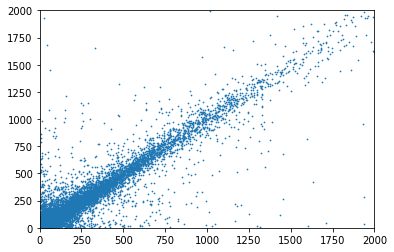

In [5]:
chunks = df.groupby(["user","both_chunk_idx","device"]).agg(step = ("step","sum")).unstack(level="device").fillna(0).droplevel(level=0, axis=1)
tmp = chunks.query("phone > 0 and watch > 0 and phone < 2000 and watch < 2000")
plt.scatter(tmp.values[:,0],tmp.values[:,1],s = .5)
plt.xlim([0,2000])
plt.ylim([0,2000])


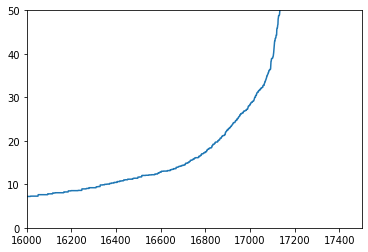

In [25]:
from sklearn import cluster
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=20).fit(tmp.values)
distances, idx = nn.kneighbors(tmp.values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim([16000,17500])
plt.ylim([0,50])
plt.show()

2
15485


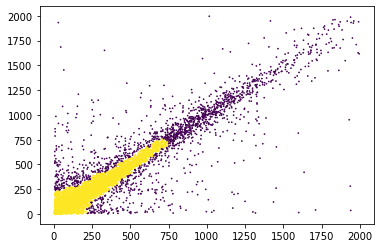

In [27]:
clustering = cluster.DBSCAN(eps = 20, min_samples = 20).fit(tmp.values)
print(len(set(clustering.labels_)))
for i in range(len(set(clustering.labels_))-1):
    print(np.sum(clustering.labels_ == i))
plt.scatter(tmp.values[:,0], tmp.values[:,1], c = clustering.labels_, s= .5)

/tmp/ipykernel_18323/235193876.py:42: RuntimeWarning: invalid value encountered in true_divide
  p_ratio = (days.values[:,0]/(days.values[:,0]+days.values[:,2])).reshape(-1,24)
/tmp/ipykernel_18323/235193876.py:43: RuntimeWarning: invalid value encountered in true_divide
  w_ratio = (days.values[:,1]/(days.values[:,1]+days.values[:,2])).reshape(-1,24)


cluster 1 has 7 points
cluster 2 has 10 points
cluster 3 has 13 points


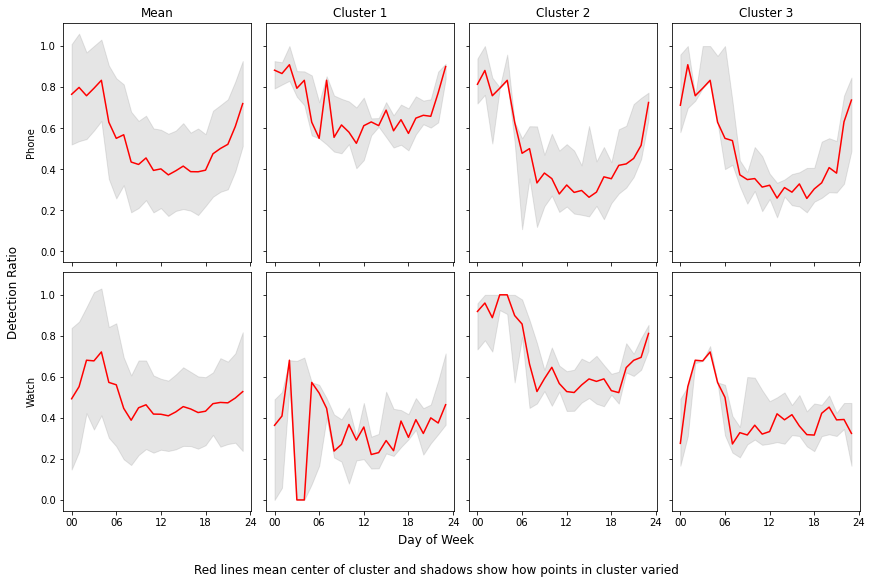

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import json

users = []
with open("../meta_data.json") as f:
    dicts = json.load(f)
    for vals in dicts.values():
        users.append(vals["folder"])
phone_color = "#ff7f0e"
watch_color = "#1f77b4"
diff_color = "#7f7f7f"
df = pd.read_excel("../Preprocess/all_user.xlsx", index_col = 0)
survey = pd.read_excel("../survey_result.xlsx")
survey["user"] = survey.index
for i in ["work_start","work_end","sleep","wake"]:
    survey[i] = pd.to_datetime(survey[i], format="%H:%M:%S")


chunks = df.groupby(["user","both_chunk_idx","device"]).agg(step = ("step","sum")).unstack(level="device").fillna(0).droplevel(level=0, axis=1)

time_info = df.groupby(["user","both_chunk_idx"]).agg(day_first = ("day","first"),day_last = ("day","last"), hour_first = ("hour","first"), hour_last = ("hour","last"), weekday_last = ("weekday","first"), weekday_first = ("weekday","last"))
time_info["week_first"] = [row["day_first"]//7 + (1 if row["day_first"]%7 - row["weekday_first"] > 0 else 0) for _,row in time_info.iterrows()]
time_info["week_last"] = [row["day_last"]//7 + (1 if row["day_last"]%7 - row["weekday_last"] > 0 else 0) for _,row in time_info.iterrows()]
chunks["detected"] = ["both" if (row["phone"] > 0 and row["watch"]> 0) else ("watch" if row["watch"] > 0 else "phone") for _, row in chunks.iterrows()]
chunks = pd.concat([chunks, time_info], axis='columns')
def n_phone(x):
    return np.sum(x == 'phone')/2
def n_watch(x):
    return np.sum(x == 'watch')/2
def n_both(x):
    return np.sum(x == 'both')/2

days_first = chunks.groupby(["user","hour_first"]).agg(p_act = ("detected", n_phone),w_act = ("detected", n_watch),b_act = ("detected", n_both))
days_first.index.rename(["user","hour"],inplace=True)
days_last = chunks.groupby(["user","hour_last"]).agg(p_act = ("detected", n_phone),w_act = ("detected", n_watch),b_act = ("detected", n_both))
days_last.index.rename(["user","hour"],inplace=True)
days = days_first.add(days_last, fill_value=0)
days = days.reindex(pd.MultiIndex.from_product([users, range(24)], names =["users","hours"])).fillna(0)
p_ratio = (days.values[:,0]/(days.values[:,0]+days.values[:,2])).reshape(-1,24)
w_ratio = (days.values[:,1]/(days.values[:,1]+days.values[:,2])).reshape(-1,24)
for i in range(24):
    p_ratio[:,i][np.isnan(p_ratio[:,i])]= np.mean(p_ratio[:,i][~np.isnan(p_ratio[:,i])])
    w_ratio[:,i][np.isnan(w_ratio[:,i])]= np.mean(w_ratio[:,i][~np.isnan(w_ratio[:,i])])
days_ratios = np.concatenate([p_ratio, w_ratio], axis = 1)

days_diff = np.zeros_like(days_ratios)
for i in range(23):
    days_diff[:,i] = days_ratios[:,i+1] - days_ratios[:,i] > 0
    days_diff[:,i+24] = days_ratios[:,i+25] - days_ratios[:,i+24] > 0   
days_diff[:,23] = days_ratios[:,0] - days_ratios[:,23] > 0
days_diff[:,47] = days_ratios[:,24] - days_ratios[:,47] > 0    


# weeks_next_ratios = np.zeros_like(days_ratios)
# permute =[1,2,3,4,5,6,0,8,9,10,11,12,13,7]
# for i in range(14):
#     weeks_next_ratios[:,i] = days_ratios[:,permute[i]]
# days_ratios = days_ratios-weeks_next_ratios

n_clusters = 3
km = cluster.KMeans(n_clusters = 3, random_state = 10).fit(days_ratios)
labels = km.labels_
centers = km.cluster_centers_
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 8), sharex = True, sharey = True, constrained_layout = True)
ax = axes.flatten()
ax[0].set_title("Mean")
q25 = np.quantile(days_ratios, q= 0.25, axis = 0)
q75 = np.quantile(days_ratios, q= 0.25, axis = 0)
median = np.quantile(days_ratios, q= 0.5, axis = 0)
mean = np.mean(days_ratios, axis = 0)
std = np.std(days_ratios, axis = 0)
ax[0].plot(range(24), mean[:24], c="r") 
ax[0].fill_between(range(24), mean[:24]-std[:24], mean[:24]+std[:24], color = "grey",alpha = 0.2)
ax[4].plot(range(24), mean[24:], c="r")
ax[4].fill_between(range(24), mean[24:]-std[24:], mean[24:]+std[24:], color = "grey",alpha = 0.2)  

each_cluster =[]
for i in range(1,4):
    ax[i].set_title(f"Cluster {i}")
    print(f"cluster {i} has {np.sum(labels == i-1)} points")
    inner_cluster = days_ratios[labels == i-1]
    each_cluster.append(np.arange(30)[labels == i-1])
#     inner_max = weeks_diff_ratios.max(axis = 0)
#     inner_min = weeks_diff_ratios.min(axis = 0)
    inner_std = inner_cluster.std(axis = 0)
    inner_mean = inner_cluster.mean(axis = 0)
    inner_mid = np.quantile(inner_cluster, q= 0.5, axis = 0)
    inner_q25 = np.quantile(inner_cluster,q=0.25,axis = 0)
    inner_q75 = np.quantile(inner_cluster, q = 0.75, axis = 0)
    #Median & quantile
    ax[i].plot(range(24), inner_mid[:24], c= 'r')
    ax[i].fill_between(range(24), inner_q25[:24], inner_q75[:24], color = "grey",alpha = 0.2)
    ax[i+4].plot(range(24), inner_mid[24:], c= 'r')
    ax[i+4].fill_between(range(24), inner_q25[24:], inner_q75[24:], color = "grey",alpha = 0.2)
    # Mean & Std
#     ax[i].plot(range(7), inner_cluster[:,:7].mean(axis = 0), c="r")
# #     ax[i].fill_between(range(7), inner_min[:7], inner_max[:7], color = "grey",alpha = 0.2)
#     ax[i].fill_between(range(7), inner_cluster[:,:7].mean(axis = 0)-inner_std[:7], inner_cluster[:,:7].mean(axis = 0)+inner_std[:7], color = "grey",alpha = 0.2)  
#     ax[i+4].plot(range(7), centers[i-1,7:], c="r")
# #     ax[i+4].fill_between(range(7), inner_min[7:], inner_max[7:], color = "grey",alpha = 0.2)
#     ax[i+4].fill_between(range(7), inner_cluster[:,7:].mean(axis = 0)-inner_std[7:], inner_cluster[:,7:].mean(axis = 0)+inner_std[7:], color = "grey",alpha = 0.2)  
    ax[i+4].set_xticks(np.arange(0,25,6))
    ax[i+4].set_xticklabels([str(i).zfill(2) for i in range(0,25,6)])
fig.supylabel("Detection Ratio")
ax[0].set_ylabel("Phone")
ax[4].set_ylabel("Watch")
fig.supxlabel('''Day of Week

Red lines mean center of cluster and shadows show how points in cluster varied''')

plt.savefig("../Fig/010.png")

cls_info = []
for i in range(3):
    cls_info.append(survey[["user","age","active_level", "work_start","work_end","sleep","wake","w_day","p_look_walk","w_usage","p_usage","afterwork_active_level","weekend_active_level"]].query(f"user in [{','.join([str(tmp) for tmp in each_cluster[i]])}]"))


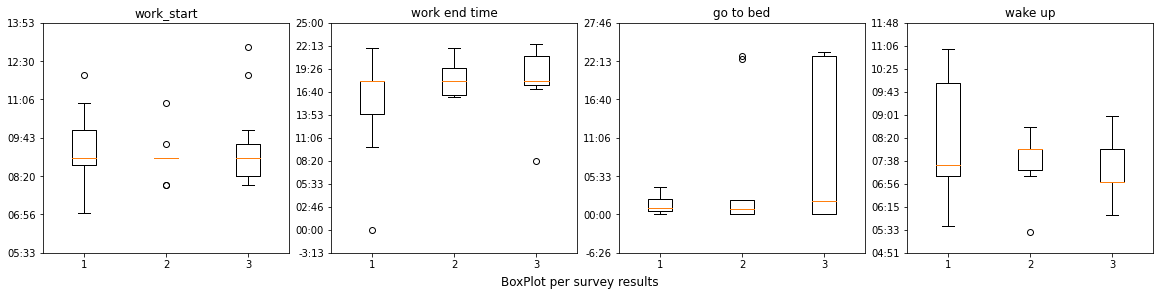

In [3]:
import datetime as dt
n_cols = 4
fig, ax = plt.subplots(nrows = 1, ncols = n_cols, figsize = (16, 4),sharex=True, constrained_layout = True)
dic = {"work_start": 3,"work_end":4,"sleep":5,"wake":6}
for idx,val in enumerate(["work_start","work_end","sleep","wake"]):
    ax[idx].boxplot([[timedelta_.seconds for timedelta_ in cls_info[i].values[:,dic[val]] - dt.datetime(1900,1,1)] for i in range(3)])
#     ax[idx].set_yticks(range(25000,45000,2500))
    ticks = ax[idx].get_yticks()
#     print(ticks)
    ax[idx].set_yticks(ticks)
    ax[idx].set_yticklabels([str(int(i)//3600).zfill(2)+":" + str((int(i)%3600)//60).zfill(2) for i in ticks])
    ax[idx].set_title(val)
    if val =="work start":
        ax[idx].set_title("work starting time")
    elif val =="work_end":
        ax[idx].set_title("work end time")
    elif val == "sleep":
        ax[idx].set_title("go to bed")
    elif val == "wake":
        ax[idx].set_title("wake up")
    ax[idx].set_xticks(range(1,4))
fig.supxlabel('''BoxPlot per survey results''')
plt.savefig("../Fig/010-2.png")
# cls_info = pd.concat(cls_info, keys = [0,1,2], ignore_index= True)
# cls_info["cluster"] = cls_info.index

In [5]:
print(cls_info[0].values[:,3])
print(cls_info[1].values[:,3])
print(cls_info[02].values[:,3])

[Timestamp('1900-01-01 00:00:00') Timestamp('1900-01-01 01:00:00')
 Timestamp('1900-01-01 03:00:00') Timestamp('1900-01-01 04:00:00')
 Timestamp('1900-01-01 00:00:00') Timestamp('1900-01-01 01:00:00')
 Timestamp('1900-01-01 01:30:00')]
[Timestamp('1900-01-01 23:00:00') Timestamp('1900-01-01 00:00:00')
 Timestamp('1900-01-01 02:10:00') Timestamp('1900-01-01 01:00:00')
 Timestamp('1900-01-01 22:30:00') Timestamp('1900-01-01 02:00:00')
 Timestamp('1900-01-01 00:30:00') Timestamp('1900-01-01 00:00:00')
 Timestamp('1900-01-01 00:00:00') Timestamp('1900-01-01 00:30:00')]
[Timestamp('1900-01-01 00:00:00') Timestamp('1900-01-01 00:00:00')
 Timestamp('1900-01-01 23:30:00') Timestamp('1900-01-01 00:00:00')
 Timestamp('1900-01-01 23:00:00') Timestamp('1900-01-01 11:20:00')
 Timestamp('1900-01-01 23:30:00') Timestamp('1900-01-01 01:00:00')
 Timestamp('1900-01-01 02:00:00') Timestamp('1900-01-01 23:00:00')
 Timestamp('1900-01-01 00:00:00') Timestamp('1900-01-01 00:00:00')
 Timestamp('1900-01-01 23: